# 二、大模型与Neo4j交互（未优化）
搭建一个Chat场景，用户通过自然语言与大模型沟通，并检索Neo4j返回相关数据。

问题：Neo4j查询语句生成逻辑并未进行优化，导致查询成功率较低，将在新的文件中处理。本节仅对整个场景进行说明

0、本地环境介绍

In [18]:
!pip install wmi

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [19]:
import wmi

# 创建WMI客户端
client = wmi.WMI()

# 查询CPU信息
for cpu in client.Win32_Processor():
    print(f"CPU 名称: {cpu.Name}")
    print(f"核心数: {cpu.NumberOfCores}")
    print(f"线程数: {cpu.NumberOfLogicalProcessors}")
    print(f"最大速度: {cpu.MaxClockSpeed} MHz")
    print(f"L2缓存大小: {cpu.L2CacheSize} KB")
    print(f"L3缓存大小: {cpu.L3CacheSize} KB")
    print(f"CPU ID: {cpu.ProcessorId}")
    print(f"制造商: {cpu.Manufacturer}")
    print(f"插座: {cpu.SocketDesignation}")
    print("---")

# 如果只需要第一个CPU的信息，可以break
# break

CPU 名称: 13th Gen Intel(R) Core(TM) i5-13600KF
核心数: 14
线程数: 20
最大速度: 3500 MHz
L2缓存大小: 8192 KB
L3缓存大小: 24576 KB
CPU ID: BFEBFBFF000B0671
制造商: GenuineIntel
插座: U3E1
---


1、准备Neo4j数据库与大模型交互对象

In [1]:
%pip install langchain_community
%pip install langchain-openai
%pip install neo4j

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install langchain

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
#准备大模型对象
# 连接Ollama测试
from langchain.chains import LLMChain
from langchain.llms import Ollama
from langchain import PromptTemplate

llm = Ollama(model="qwen:7b" ,temperature=0)
# Prompt
template = """Tell me a joke about {topic}"""
QA_CHAIN_PROMPT = PromptTemplate(
        input_variables=["topic"],
        template=template,
    )

test_chain = LLMChain(
    llm = llm,
    prompt = QA_CHAIN_PROMPT)

response = test_chain("tiger")
print(response)

d:\Document\BaiduSyncdisk\MSE-Files\LLM_RAG\Project\Intel_RagNeo4j\.venv\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


{'topic': 'tiger', 'text': 'Why did the tiger refuse to move? \n\nBecause it was a stand-up tiger!\n'}


2、定义工具包，包含Cypher查询

In [4]:
# 定义一个工具包，包含执行Cypher查询的方法
from langchain_community.graphs import Neo4jGraph
import json

graph= Neo4jGraph(
    url="neo4j://127.0.0.1:7687",
    username="neo4j",
    password="dswzlygs",
    database="demo")


class MyCustomToolkit:
    def __init__(self, graph: Neo4jGraph):
        self._driver = graph

    def execute_cypher_query(self, cypher_query:str = None, **params):
        # 执行Cypher查询并返回结果
        try:
            return json.dumps(self._driver.query(cypher_query),indent=4)
        except Exception as e:
            print(f"An error occurred: {e}")
        

toolkit = MyCustomToolkit(graph)

# 定义Cypher查询
cypher_query = "MATCH (n:Patient) RETURN n LIMIT 25"

# 调用函数并传入toolkit的Cypher查询
print(toolkit.execute_cypher_query(cypher_query))

[
    {
        "n": {
            "patient_dob": "1994-10-06",
            "patient_sex": "Female",
            "patient_id": "0",
            "blood_type": "O+",
            "name": "Tiffany Ramirez",
            "patient_name": "Tiffany Ramirez"
        }
    },
    {
        "n": {
            "patient_dob": "1973-03-31",
            "patient_sex": "Male",
            "patient_id": "1",
            "blood_type": "A-",
            "name": "Ruben Burns",
            "patient_name": "Ruben Burns"
        }
    },
    {
        "n": {
            "patient_dob": "1932-05-10",
            "patient_sex": "Male",
            "patient_id": "2",
            "blood_type": "O-",
            "name": "Chad Byrd",
            "patient_name": "Chad Byrd"
        }
    },
    {
        "n": {
            "patient_dob": "1944-10-04",
            "patient_sex": "Male",
            "patient_id": "3",
            "blood_type": "AB+",
            "name": "Antonio Frederick",
            "patient_name": 

3、定义与Neo4j交互的Agent与Chain

In [5]:
# # 用于生成Cypher语句的提示词
# from langchain import PromptTemplate
# # ...

# cypher_generation_template_en = """
# Task:
# Generate Cypher query for a Neo4j graph database.

# Instructions:
# Use only the provided relationship types and properties in the schema.
# Do not use any other relationship types or properties that are not provided.

# Schema:
# {schema}

# 1. Neo4j数据库中有6个Labels，分别是："Hospital"、"Patient" 、"Payer"、"Physician"、"Review" 和"Visit"  
# 2.上述Labels代表的Node分别有以下字段
#   2.1 Hospital
#     hospital_id: 一个整数，用于唯一标识一家医院。
#     hospital_name: 医院的名称。
#     hospital_state: 医院所在的州。
#   2.2 Patient
#     physician_id: 一个整数，用于唯一标识每位医生。
#     physician_name: 医生的姓名。
#     physician_dob: 医生的出生日期。
#     physician_grad_year: 医生毕业于医学院的年份。
#     medical_school: 医生就读的医学院。
#     salary: 医生的薪水。
#   2.3 Payer
#     payer_id: 一个整数，用于唯一标识每位支付方。
#     payer_name: 支付方的公司名称。
#   2.4 Physician
#     physician_id: 一个整数，用于唯一标识每位医生。
#     physician_name: 医生的姓名。
#     physician_dob: 医生的出生日期。
#     physician_grad_year: 医生毕业于医学院的年份。
#     medical_school: 医生就读的医学院。
#     salary: 医生的薪水。
#   2.5 Review
#     review_id: 一个整数，用于唯一标识一条评价。
#     visit_id: 一个整数，标识患者就诊的评价所涉及的就诊。
#     review: 患者留下的自由形式文本评价。
#     physician_name: 治疗患者的医生姓名。
#     hospital_name: 患者住院的医院名称。
#     patient_name: 患者的姓名。
#   2.6 Visit
#     visit_id: 医院就诊的唯一标识符。
#     patient_id: 与就诊相关联的患者ID。
#     date_of_admission: 患者入院的日期。
#     room_number: 患者的房间号。
#     admission_type: 'Elective'（选择性）、'Emergency'（紧急）或'Urgent'（紧迫）之一。
#     chief_complaint: 描述患者到医院的主要原因的字符串。
#     primary_diagnosis: 医生做出的主要诊断的描述。
#     treatment_description: 医生给予的治疗的文本摘要。
#     test_results: 'Inconclusive'（不确定）、'Normal'（正常）或'Abnormal'（异常）之一。
#     discharge_date: 患者出院的日期。
#     physician_id: 治疗患者的医生ID。
#     hospital_id: 患者住院的医院ID。
#     payer_id: 患者使用的保险支付方ID。
#     billing_amount: 向支付方开具的就诊费用金额。
#     visit_status: 'OPEN'（开放）或'DISCHARGED'（已出院）之一
# 3.Neo4j数据库中有6种关系，分别是："COVERED_BY" 、"HAS" 、"AT"、"TREATS"、"WRITES"和"EMPLOYS"  
#     3.1 A "Patient" "HAS" a "visit" "AT" a "Hospital"
#     3.2 "Hospital" "EMPLOYS" a "Physician" to "TREATS" the "Visit" which is "COVERED_BY" an insurance "Payer"

# Note:
# Do not include any explanations or apologies in your responses.
# Do not respond to any questions that might ask anything other than
# for you to construct a Cypher statement. Do not include any text except
# the generated Cypher statement. Make sure the direction of the relationship is
# correct in your queries. Make sure you alias both entities and relationships
# properly. Do not run any queries that would add to or delete from
# the database. Make sure to alias all statements that follow as with
# statement (e.g. WITH v as visit, c.billing_amount as billing_amount)
# If you need to divide numbers, make sure to
# filter the denominator to be non zero.

# Examples:
# # 请给我患者:“Michael Bradshaw”的就诊记录
# MATCH (p:Patient) 
# -[:HAS]-(v:Visit)
# WHERE p.patient_name = 'Michael Bradshaw' 
# RETURN v

# # “Richardson-Powell” 医院在2020年之后，治疗了多少患者？
# MATCH (p:Patient)-[:HAS]->(v:Visit)-[:AT]->(h:Hospital)
# where h.hospital_name = 'Richardson-Powell' and date(v.date_of_admission) > date('2020-01-01')
#   return count(p)

# # 年级最大的患者是谁，他或她的年龄是多少？
# MATCH (p:Patient)
# RETURN p.patient_name AS oldest_patient,
#        duration.between(date(p.patient_dob), datetime()).years AS age
# ORDER BY age DESC
# LIMIT 1


# # 从2022年到2023年，哪个州的Cigna就诊次数百分比增长最大？
# MATCH (h:Hospital)<-[:AT]-(v:Visit)-[:COVERED_BY]->(p:Payer)
# WHERE p.payer_name = 'Cigna' AND date(v.date_of_admission) >= date('2022-01-01') AND
# date(v.date_of_admission) < date('2024-01-01')
# WITH h.hospital_state AS state, COUNT(v) AS visit_count,
#      SUM(CASE WHEN date(v.date_of_admission) >= date('2022-01-01') AND
#      date(v.date_of_admission) < date('2023-01-01') THEN 1 ELSE 0 END) AS count_2022,
#      SUM(CASE WHEN date(v.date_of_admission) >= date('2023-01-01') AND
#      date(v.date_of_admission) < date('2024-01-01') THEN 1 ELSE 0 END) AS count_2023
# WITH state, visit_count, count_2022, count_2023,
#      (toFloat(count_2023) - toFloat(count_2022)) / toFloat(count_2022) * 100
#      AS percent_increase
# RETURN state, percent_increase
# ORDER BY percent_increase DESC
# LIMIT 1

# # 在北卡罗来纳州（North Carolina，NC），有多少非急诊患者写了评价？
# MATCH (r:Review)<-[:WRITES]-(v:Visit)-[:AT]->(h:Hospital)
# WHERE h.hospital_state = 'NC' and v.admission_type <> 'Emergency'
# RETURN count(*)


# String category values:
# Test results are one of: 'Inconclusive', 'Normal', 'Abnormal'
# Visit statuses are one of: 'OPEN', 'DISCHARGED'
# Admission Types are one of: 'Elective', 'Emergency', 'Urgent'
# Payer names are one of: 'Cigna', 'Blue Cross', 'UnitedHealthcare', 'Medicare',
# 'Aetna'

# A visit is considered open if its status is 'OPEN' and the discharge date is
# missing.
# Use abbreviations when
# filtering on hospital states (e.g. "Texas" is "TX",
# "Colorado" is "CO", "North Carolina" is "NC",
# "Florida" is "FL", "Georgia" is "GA", etc.)

# Make sure to use IS NULL or IS NOT NULL when analyzing missing properties.
# Never return embedding properties in your queries. You must never include the
# statement "GROUP BY" in your query. Make sure to alias all statements that
# follow as with statement (e.g. WITH v as visit, c.billing_amount as
# billing_amount)
# If you need to divide numbers, make sure to filter the denominator to be non
# zero.

# The question is:
# {question}
# """



# cypher_generation_template_cn = """
# Task:
# 生成用于Neo4j数据库执行的Cypher查询语句。


# Instructions:
# 仅使用模式中提供的关系类型和属性。
# 不要使用任何未提供的其他关系类型或属性。
# 收到用户信息后，首先根据Neo4j数据库结构，生成查询语句后进行查询。不要根据大模型既有信息进行反馈。

# Schema:
# {schema}
# 1. Neo4j数据库中有6个Labels，分别是："Hospital"、"Patient" 、"Payer"、"Physician"、"Review" 和"Visit"  
# 2.上述Labels代表的Node分别有以下字段
#   2.1 Hospital
#     hospital_id: 一个整数，用于唯一标识一家医院。
#     hospital_name: 医院的名称。
#     hospital_state: 医院所在的州。
#   2.2 Patient
#     physician_id: 一个整数，用于唯一标识每位医生。
#     physician_name: 医生的姓名。
#     physician_dob: 医生的出生日期。
#     physician_grad_year: 医生毕业于医学院的年份。
#     medical_school: 医生就读的医学院。
#     salary: 医生的薪水。
#   2.3 Payer
#     payer_id: 一个整数，用于唯一标识每位支付方。
#     payer_name: 支付方的公司名称。
#   2.4 Physician
#     physician_id: 一个整数，用于唯一标识每位医生。
#     physician_name: 医生的姓名。
#     physician_dob: 医生的出生日期。
#     physician_grad_year: 医生毕业于医学院的年份。
#     medical_school: 医生就读的医学院。
#     salary: 医生的薪水。
#   2.5 Review
#     review_id: 一个整数，用于唯一标识一条评价。
#     visit_id: 一个整数，标识患者就诊的评价所涉及的就诊。
#     review: 患者留下的自由形式文本评价。
#     physician_name: 治疗患者的医生姓名。
#     hospital_name: 患者住院的医院名称。
#     patient_name: 患者的姓名。
#   2.6 Visit
#     visit_id: 医院就诊的唯一标识符。
#     patient_id: 与就诊相关联的患者ID。
#     date_of_admission: 患者入院的日期。
#     room_number: 患者的房间号。
#     admission_type: 'Elective'（选择性）、'Emergency'（紧急）或'Urgent'（紧迫）之一。
#     chief_complaint: 描述患者到医院的主要原因的字符串。
#     primary_diagnosis: 医生做出的主要诊断的描述。
#     treatment_description: 医生给予的治疗的文本摘要。
#     test_results: 'Inconclusive'（不确定）、'Normal'（正常）或'Abnormal'（异常）之一。
#     discharge_date: 患者出院的日期。
#     physician_id: 治疗患者的医生ID。
#     hospital_id: 患者住院的医院ID。
#     payer_id: 患者使用的保险支付方ID。
#     billing_amount: 向支付方开具的就诊费用金额。
#     visit_status: 'OPEN'（开放）或'DISCHARGED'（已出院）之一
# 3.Neo4j数据库中有6种关系，分别是："COVERED_BY" 、"HAS" 、"AT"、"TREATS"、"WRITES"和"EMPLOYS"  
#     3.1 A "Patient" "HAS" a "visit" "AT" a "Hospital"
#     3.2 "Hospital" "EMPLOYS" a "Physician" to "TREATS" the "Visit" which is "COVERED_BY" an insurance "Payer"

    
# 说明:
# 不要在回答中包含任何解释、说明或道歉等各种礼仪用语。
# 不要回答任何可能会要求你做除了构建Cypher语句之外的任何事情的问题。
# 除了生成的Cypher语句之外，不要包含任何文本。 
# 确保查询中关系的方向是正确的。 
# 确保正确地为两个实体和关系设置别名。
# 不要运行任何会增加或删除数据库内容的查询。
# 不要设置别名，使用数据库中原有字段名称
# 如果你需要进行数字除法，确保过滤分母不为零。
# 有where条件时，请在match 语句之后添加Where内容。

# 举例:
# # 请给我患者:'Michael Bradshaw' 的就诊时间和入院类别
# MATCH (p:Patient ) -[:HAS]->(v:Visit)
# WHERE p.patient_name = 'Michael Bradshaw'
# RETURN v.date_of_admission,v.admission_type 

# # “Richardson-Powell” 医院在2020年之后，治疗了多少患者？
# MATCH (p:Patient)-[:HAS]->(v:Visit)-[:AT]->(h:Hospital)
# where h.hospital_name = 'Richardson-Powell'
#      and date(v.date_of_admission) > date('2020-01-01')
#   return count(p)

# # 年级最大的患者是谁，他或她的年龄是多少？
# MATCH (p:Patient)
# RETURN p.patient_name AS oldest_patient,
#        duration.between(date(p.patient_dob), datetime()).years AS age
# ORDER BY age DESC
# LIMIT 1


# # 从2022年到2023年，哪个州的Cigna就诊次数百分比增长最大？
# MATCH (h:Hospital)<-[:AT]-(v:Visit)-[:COVERED_BY]->(p:Payer)
# WHERE p.payer_name = 'Cigna' AND date(v.date_of_admission) >= date('2022-01-01') AND
# date(v.date_of_admission) < date('2024-01-01')
# WITH h.hospital_state AS state, COUNT(v) AS visit_count,
#      SUM(CASE WHEN date(v.date_of_admission) >= date('2022-01-01') AND
#      date(v.date_of_admission) < date('2023-01-01') THEN 1 ELSE 0 END) AS count_2022,
#      SUM(CASE WHEN date(v.date_of_admission) >= date('2023-01-01') AND
#      date(v.date_of_admission) < date('2024-01-01') THEN 1 ELSE 0 END) AS count_2023
# WITH state, visit_count, count_2022, count_2023,
#      (toFloat(count_2023) - toFloat(count_2022)) / toFloat(count_2022) * 100
#      AS percent_increase
# RETURN state, percent_increase
# ORDER BY percent_increase DESC
# LIMIT 1

# # 在北卡罗来纳州（North Carolina，NC），有多少非急诊患者写了评价？
# MATCH (r:Review)<-[:WRITES]-(v:Visit)-[:AT]->(h:Hospital)
# WHERE h.hospital_state = 'NC' and v.admission_type <> 'Emergency'
# RETURN count(*)

# String category values:
# 测试结果为以下之一: 'Inconclusive', 'Normal', 'Abnormal'，分别代表“不确定”，“正常”和“异常”
# 就诊状态为以下之一: 'OPEN', 'DISCHARGED'，分别代表“进行中”与“已出院”
# 入院类型为以下之一: 'Elective', 'Emergency', 'Urgent'，分别代表“门诊”、“急诊”和“危急”
# 支付方名称为以下之一: 'Cigna', 'Blue Cross', 'UnitedHealthcare', 'Medicare','Aetna'

# 当Visit中的visit_status 是“Open”，代表患者还在治疗中，此时discharge_date 字段为空
# 当检索医院所在州的信息时，请在hospital_state字段中使用简称，比如（"Texas" 用 "TX","Colorado" 用 "CO", "North Carolina" 用 "NC","Florida" 用 "FL", "Georgia" is "GA"）


# 确保在分析缺失属性时使用IS NULL或IS NOT NULL。
# 在查询中永远不要返回嵌入的属性。你绝不能在查询中包含“GROUP BY”语句。
# 确保像以下这样为所有后续语句设置别名（例如 WITH v as visit, c.billing_amount as billing_amount）。
# 如果你需要进行数字除法，确保过滤分母不为零。

# The question is:
# {question}
# """

# cypher_generation_prompt = PromptTemplate(
#     input_variables=["schema", "question"], template=cypher_generation_template_en
# )

In [6]:
# ...

cypher_generation_template = """
Task:
Generate Cypher query for a Neo4j graph database.

Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.

Schema:
{schema}

Note:
Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything other than
for you to construct a Cypher statement. Do not include any text except
the generated Cypher statement. Make sure the direction of the relationship is
correct in your queries. Make sure you alias both entities and relationships
properly. Do not run any queries that would add to or delete from
the database. Make sure to alias all statements that follow as with
statement (e.g. WITH v as visit, c.billing_amount as billing_amount)
If you need to divide numbers, make sure to
filter the denominator to be non zero.

Examples:
# Who is the oldest patient and how old are they?
MATCH (p:Patient)
RETURN p.name AS oldest_patient,
       duration.between(date(p.dob), date()).years AS age
ORDER BY age DESC
LIMIT 1

# Which physician has billed the least to Cigna
MATCH (p:Payer)<-[c:COVERED_BY]-(v:Visit)-[t:TREATS]-(phy:Physician)
WHERE p.name = 'Cigna'
RETURN phy.name AS physician_name, SUM(c.billing_amount) AS total_billed
ORDER BY total_billed
LIMIT 1

# Which state had the largest percent increase in Cigna visits
# from 2022 to 2023?
MATCH (h:Hospital)<-[:AT]-(v:Visit)-[:COVERED_BY]->(p:Payer)
WHERE p.name = 'Cigna' AND v.admission_date >= '2022-01-01' AND
v.admission_date < '2024-01-01'
WITH h.state_name AS state, COUNT(v) AS visit_count,
     SUM(CASE WHEN v.admission_date >= '2022-01-01' AND
     v.admission_date < '2023-01-01' THEN 1 ELSE 0 END) AS count_2022,
     SUM(CASE WHEN v.admission_date >= '2023-01-01' AND
     v.admission_date < '2024-01-01' THEN 1 ELSE 0 END) AS count_2023
WITH state, visit_count, count_2022, count_2023,
     (toFloat(count_2023) - toFloat(count_2022)) / toFloat(count_2022) * 100
     AS percent_increase
RETURN state, percent_increase
ORDER BY percent_increase DESC
LIMIT 1

# How many non-emergency patients in North Carolina have written reviews?
MATCH (r:Review)<-[:WRITES]-(v:Visit)-[:AT]->(h:Hospital)
WHERE h.state_name = 'NC' and v.admission_type <> 'Emergency'
RETURN count(*)

String category values:
Test results are one of: 'Inconclusive', 'Normal', 'Abnormal'
Visit statuses are one of: 'OPEN', 'DISCHARGED'
Admission Types are one of: 'Elective', 'Emergency', 'Urgent'
Payer names are one of: 'Cigna', 'Blue Cross', 'UnitedHealthcare', 'Medicare',
'Aetna'

A visit is considered open if its status is 'OPEN' and the discharge date is
missing.
Use abbreviations when
filtering on hospital states (e.g. "Texas" is "TX",
"Colorado" is "CO", "North Carolina" is "NC",
"Florida" is "FL", "Georgia" is "GA", etc.)

Make sure to use IS NULL or IS NOT NULL when analyzing missing properties.
Never return embedding properties in your queries. You must never include the
statement "GROUP BY" in your query. Make sure to alias all statements that
follow as with statement (e.g. WITH v as visit, c.billing_amount as
billing_amount)
If you need to divide numbers, make sure to filter the denominator to be non
zero.

The question is:
{question}
"""

cypher_generation_prompt = PromptTemplate(
    input_variables=["schema", "question"], template=cypher_generation_template
)

In [7]:
# ...

qa_generation_template_en = """You are an assistant that takes the results
from a Neo4j Cypher query and forms a human-readable response. The
query results section contains the results of a Cypher query that was
generated based on a user's natural language question. The provided
information is authoritative, you must never doubt it or try to use
your internal knowledge to correct it. Make the answer sound like a
response to the question.

Query Results:
{context}

Question:
{question}

If the provided information is empty, say you don't know the answer.
Empty information looks like this: [{context} , the provided information is empty ]

If the information is not empty, you must provide an answer using the
results. If the question involves a time duration, assume the query
results are in units of days unless otherwise specified.

When names are provided in the query results, such as hospital names,
beware  of any names that have commas or other punctuation in them.
For instance, 'Jones, Brown and Murray' is a single hospital name,
not multiple hospitals. Make sure you return any list of names in
a way that isn't ambiguous and allows someone to tell what the full
names are.

Never say you don't have the right information if there is data in
the query results. Always use the data in the query results.

Helpful Answer:
"""

qa_generation_template = """You are an assistant that takes the results
from a Neo4j Cypher query and forms a human-readable response. The
query results section contains the results of a Cypher query that was
generated based on a user's natural language question. The provided
information is authoritative, you must never doubt it or try to use
your internal knowledge to correct it. Make the answer sound like a
response to the question.

Query Results:
{context}

Question:
{question}

If the provided information is empty, say you don't know the answer.
Empty information looks like this: []

If the information is not empty, you must provide an answer using the
results. If the question involves a time duration, assume the query
results are in units of days unless otherwise specified.

When names are provided in the query results, such as hospital names,
beware  of any names that have commas or other punctuation in them.
For instance, 'Jones, Brown and Murray' is a single hospital name,
not multiple hospitals. Make sure you return any list of names in
a way that isn't ambiguous and allows someone to tell what the full
names are.

Never say you don't have the right information if there is data in
the query results. Always use the data in the query results.

Helpful Answer:
"""

qa_generation_prompt = PromptTemplate(
    input_variables=["context", "question"], template=qa_generation_template_en
)

In [8]:

from langchain.llms import Ollama
from langchain_community.graphs import Neo4jGraph

llm = Ollama(model="qwen:7b",temperature=0.2)

graph= Neo4jGraph(
    url="neo4j://127.0.0.1:7687",
    username="neo4j",
    password="dswzlygs",
    database="demo")


from langchain.chains import GraphCypherQAChain
hospital_cypher_chain = GraphCypherQAChain.from_llm(
    cypher_llm=llm,
    qa_llm=llm,
    graph=graph,
    verbose=True,
    qa_prompt=qa_generation_prompt,
    cypher_prompt=cypher_generation_prompt,
    validate_cypher=True,
    top_k=100,    
)

In [9]:
import time
start_time = time.time()

#question = """请查找患者名字是'Patty Norman' 的入院时间和出院时间"""
question = """Please look for the ID and blood type of the Patient named "Christina Williams", I think the field name of blood type will be like patient blood type. """
response = hospital_cypher_chain.invoke(question)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"服务调用花费了 {elapsed_time} 秒")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Patient) WHERE p.name = 'Christina Williams' RETURN p.patient_id AS id, p.blood_type AS blood_type

Full Context:
[{'id': '12', 'blood_type': 'O-'}, {'id': '8815', 'blood_type': 'AB+'}]

> Finished chain.
服务调用花费了 67.90467405319214 秒


In [12]:
start_time = time.time()

#question = """请查找患者名字是'Patty Norman' 的入院时间和出院时间"""
question = """你好，我想咨询一些医疗方面的信息，你能帮助我么？ """
# 连接Ollama测试
from openai import OpenAI

client = OpenAI(
    base_url = 'http://localhost:11434/v1',
    api_key='ollama', # required, but unused
)

response = client.chat.completions.create(
  model="qwen:7b",
  messages=[
    {"role": "user", "content": question},
  ]
)
print(response.choices[0].message.content)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"服务调用花费了 {elapsed_time} 秒")

当然可以，我很乐意为你提供医疗信息和解答相关问题。但需要注意的是，我的回答只能作为参考，具体病情还需要你到正规医院就诊，由专业医生进行诊断和治疗。希望这个提示对你有所帮助！

服务调用花费了 3.988042116165161 秒


In [13]:
start_time = time.time()

#question = """请查找患者名字是'Patty Norman' 的入院时间和出院时间"""
question = """我被开水烫伤了左手，请问应该如何处理？ """
# 连接Ollama测试

response = client.chat.completions.create(
  model="qwen:7b",
  messages=[
    {"role": "user", "content": question},
  ]
)
print(response.choices[0].message.content)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"服务调用花费了 {elapsed_time} 秒")

当你被开水烫伤时，应立即采取以下急救步骤：

1. **迅速冷却**：立即用流动的冷水冲洗受伤部位，持续几分钟，帮助降低热度。

2. **避免使用酒精**：尽管有些人会认为酒精可以帮助消炎，但酒精可能会刺激皮肤并延缓伤口愈合。

3. **脱去被热水浸湿的衣服**：如果衣服粘在皮肤上，尝试慢慢脱下。注意不要撕裂皮肤或拉伤肌肉。

4. **清洁和处理伤口**：用干净的布或纱布轻轻擦拭伤口，清除可能存在的碎片。避免自行剪开水泡，它们通常可以自行破裂并促进愈合。

5. **观察及就医**：仔细观察烫伤部位是否有红肿、疼痛加剧或其他异常情况。如果情况严重，应立即去医院寻求专业医疗救治。

服务调用花费了 6.83075475692749 秒


注：为了降低Demo难度，对Cypher生成脚本进行简化处理，具体调整如下：

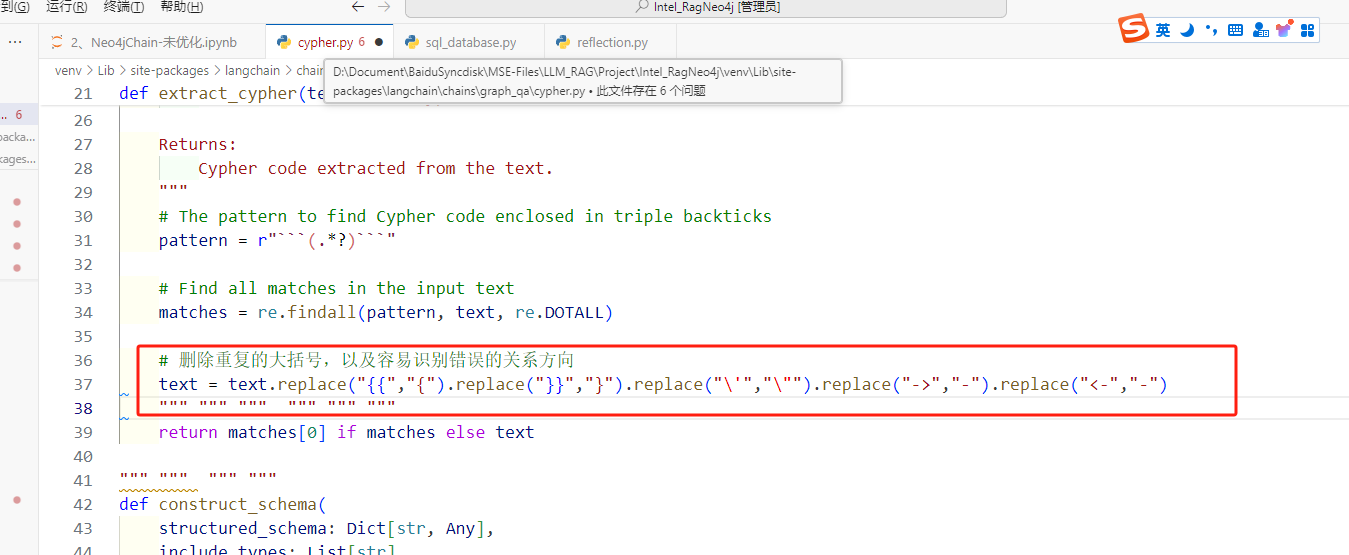